# Pothole Localization

In [95]:
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np
import scipy
import cv2
import math
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET
%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import tensorflow.keras.utils
from sklearn.model_selection import train_test_split

### Loading Data

In [96]:
absFolder=os.getcwd()
parentFolder = os.path.dirname(absFolder)
dataFolder = os.path.join(parentFolder, 'Data')
allImagesFolder = dataFolder
# allImagesFolder = os.path.join(dataFolder, 'all')

In [97]:
# create a daraframe and load it with the labels from Pascal VOC xml files

labels = []

for filename in os.listdir(allImagesFolder):
    if filename.endswith(".xml"):
        filepath = os.path.join(allImagesFolder, filename)
        xml = ET.parse(filepath)
        annot = xml.getroot()
        fName = annot.find('filename').text
        size = annot.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        if width<40 or height<40 or width >999999 or height> 999999:
            continue
        
        objects = annot.findall('object')
        if len(objects)!=1:
            pass
        elif objects[0].find('name').text=='pothole':
            box = objects[0].find('bndbox')
            
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
            
            if xmin<0 or xmax>width or ymin<0 or ymax>height:
                continue
            
            labels.append([fName, width, height, "pothole", xmin, ymin, xmax, ymax])

labelDf = pd.DataFrame(labels, 
                       columns=["filename", "width", 'height', "class", 'xmin', 'ymin', 'xmax', 'ymax'])


In [98]:
labelDf.describe()

,width,height,xmin,ymin,xmax,ymax
count,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000
mean,1837.541032,1039.779428,472.306350,343.028593,1271.992573,584.709246
std,322.544096,168.525450,330.404822,188.164161,397.186344,202.654754
min,200.000000,129.000000,1.000000,1.000000,116.000000,77.000000
25%,1920.000000,1080.000000,195.000000,186.000000,1039.000000,430.000000
50%,1920.000000,1080.000000,435.000000,369.000000,1285.000000,607.000000
75%,1920.000000,1080.000000,701.000000,500.000000,1558.000000,730.000000
max,4032.000000,3024.000000,1430.000000,1611.000000,2309.000000,2211.000000


In [99]:
labelDf.isnull().sum()

filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [100]:
newSize = (128, 128)

labelDf.xmin = labelDf.xmin/labelDf.width
labelDf.xmax = labelDf.xmax/labelDf.width
labelDf.ymin = labelDf.ymin/labelDf.height
labelDf.ymax = labelDf.ymax/labelDf.height

labelDf['w'] = labelDf.xmax - labelDf.xmin
labelDf['h'] = labelDf.ymax - labelDf.ymin

In [101]:
labelDf.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,w,h
0,20200211_163006_00351.jpg,1920,1080,pothole,0.452604,0.511111,0.660937,0.620370,0.208333,0.109259
1,20200211_163107-00138.jpg,1920,1080,pothole,0.612500,0.423148,0.976562,0.650926,0.364062,0.227778
2,20200211_163107-00165.jpg,1920,1080,pothole,0.563021,0.314815,0.959896,0.550000,0.396875,0.235185
3,Pothole4-0557.jpg,1920,1080,pothole,0.111458,0.186111,0.568229,0.401852,0.456771,0.215741
4,Pothole4-0635.jpg,1920,1080,pothole,0.005208,0.159259,0.414062,0.323148,0.408854,0.163889


In [102]:
def retrieveImage(fName):
    fPath = os.path.join(allImagesFolder, fName)
    pic = np.asarray(Image.open(fPath).convert('RGB').resize(newSize)) / 255.0
    return pic

In [103]:
# retrieve the images linked in the annotations
X = np.array(labelDf.filename.apply(retrieveImage).tolist())

In [104]:
Y = labelDf[['xmin', 'ymin', 'w', 'h']].to_numpy()

### Split data for training and testing

In [105]:
# do a random split to train and test
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=41)

In [106]:
# find the single images for testing and rest training
test_indices = np.where(labelDf['filename'].str.len() < 8)
train_indices = np.where(labelDf['filename'].str.len() >= 8)

X_train = np.squeeze(np.take(X, train_indices, axis=0))
Y_train = np.squeeze(np.take(Y, train_indices, axis=0))
X_test = np.squeeze(np.take(X, test_indices, axis=0))
Y_test = np.squeeze(np.take(Y, test_indices, axis=0))

In [107]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2489, 128, 128, 3)
(2489, 4)
(204, 128, 128, 3)
(204, 4)


### Data Augmentation

In [108]:
def move_to_center(point):
    x = point[0] - 0.5
    y = 0.5 - point[1]
    
#     print("Centered:", end=' ')
#     print([x,y])
    return [x,y] # TODO make ndarray
def convert_to_polar(vec):
    r1 = math.sqrt(vec[0]**2+vec[1]**2)
    theta1 = math.atan2(vec[1],vec[0])
    vec[0], vec[1] = r1, theta1
#     print("Polar:", end=' ')
#     print(vec)
    return vec
def rotate(vec, deg):
    rads = math.radians(deg)
    vec[1] = vec[1] + rads
#     print("Rotated:", end=' ')
#     print(vec)
    return vec
def convert_cartesian(vec):
    vec[0], vec[1] = vec[0]*math.cos(vec[1]), vec[0]*math.sin(vec[1])
#     print("Cartesian:", end=' ')
#     print(vec)
    return vec
def move_upper_left(vec):
    vec[0] = vec[0] + 0.5
    vec[1] = 0.5 - vec[1]
#     print("Back to top left:", end=' ')
#     print(vec)
    return vec

In [109]:
def rotate_coords(box, deg):
#     print(box)
#     print('\n')
#     print("Doing top left...")
    topLeft = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0], box[1]])), deg)))
#     print("Doing top right...")
    topRight = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0]+box[2], box[1]])), deg)))
    bottomLeft = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0], box[1]+box[3]])), deg)))
    bottomRight = move_upper_left(convert_cartesian(rotate(convert_to_polar(move_to_center([box[0]+box[2], box[1]+box[3]])), deg)))
    
    nx = min(topLeft[0], topRight[0], bottomLeft[0], bottomRight[0])
    ny = min(topLeft[1], topRight[1], bottomLeft[1], bottomRight[1])
    nw = max(topLeft[0], topRight[0], bottomLeft[0], bottomRight[0]) - nx
    nh = max(topLeft[1], topRight[1], bottomLeft[1], bottomRight[1]) - ny
    
#     nx = 10/128
#     ny = 10/128
#     nw = 30/128
#     nh = 30/128
    
    box[0], box[1], box[2], box[3] = nx, ny, nw, nh
#     print(box)
    return box

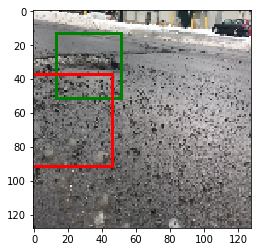

In [110]:
# show that the rotation is working. 
box1 = np.array([.10, .10, .30, .30])

fig = plt.figure()
plt.imshow(X[4])
a1 = plt.gca()
rect = pat.Rectangle((box1[0]*128.0,box1[1]*128.0),box1[2]*128.0,box1[3]*128.0, linewidth = 3, edgecolor='g', facecolor='none')
a1.add_patch(rect)

rotatedBox = rotate_coords(box1, 45) * 128.0
rect = pat.Rectangle((rotatedBox[0],rotatedBox[1]),rotatedBox[2],rotatedBox[3], linewidth = 3, edgecolor='r', facecolor='none')
a1.add_patch(rect)

In [111]:
max_brightness_factor = 0.2
max_rotation_angle = 40
max_shift = 0.15

class PotholeBatchGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, 
                x_set,
                y_set,
                batch_size,
                image_dims=newSize,
                 shuffle=True,
                 num_channels=3,
                 num_outputs=4,
                 is_train=True):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dims = image_dims
        self.shuffle=shuffle
        self.num_channels = num_channels
        self.num_outputs = num_outputs
        self.num_images = self.x.shape[0]
        self.indexes = np.arange(self.num_images)
        self.is_train = is_train
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(self.num_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.num_images)
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dims, self.num_channels))
        y = np.empty((self.batch_size, self.num_outputs))
        
        for i in range(self.batch_size):
            y[i,:] = self.y[batch_indexes[i],:]
            
            flip_flag = np.random.randint(2)
            if flip_flag ==1 and self.is_train:
                x[i, :, :, :] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
                y[i, 0] = 1-y[i, 0] - y[i, 2]
            else:
                x[i, :, :, :] = self.x[batch_indexes[i],:,:,:]
                
            
            
            
            if self.is_train:
                brightness_mult = np.random.random()*max_brightness_factor*2 - max_brightness_factor + 1
                x[i,:,:,:] = brightness_mult * x[i,:,:,:]
                
        if self.is_train:
            angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
            
            for i in range(self.batch_size):
                y[i, :] = rotate_coords(y[i, :], angle)
            x = scipy.ndimage.interpolation.rotate(x, angle, (2,1), False, mode="constant", cval=0, order=0)
            
            shift = np.random.random()*2*max_shift - max_shift
#             shift=0.2
            M = np.float32([[1,0,shift*newSize[0]], [0,1,0]])
            
#             x = scipy.ndimage.interpolation.shift(x, (0, 0, shift*newSize[0],  0), mode="constant", cval=0)
            for i in range(self.batch_size):
                y[i, 0] += shift
                x[i] = cv2.warpAffine(x[i], M, newSize)
            
        else:
            angle = 0
            shift = 0
        
        
        
        return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2.0516697144349934, 12.907043695563836, 148.98082137424856, 124.63886001078171)
(28.920204895197266, 85.63753781909531, 27.347197171915603, 21.170654087202948)
(46.54009680921393, 28.67633690355693, 52.10731644966669, 42.73458452706559)
(32.80189964922754, 58.96926292467726, 77.16647147155467, 55.8080314068718)
(58.12150455990935, 53.499483800856794, 49.60921719036296, 39.99768954998858)
(44.90453741689879, 52.9571043390351, 81.79127881509915, 55.523749860038706)
(34.6361953161826, -12.503776271721634, 81.1853818143965, 55.21634750655264)
(13.799054180173115, 77.03640906124966, 29.361643012334426, 23.148362124887427)


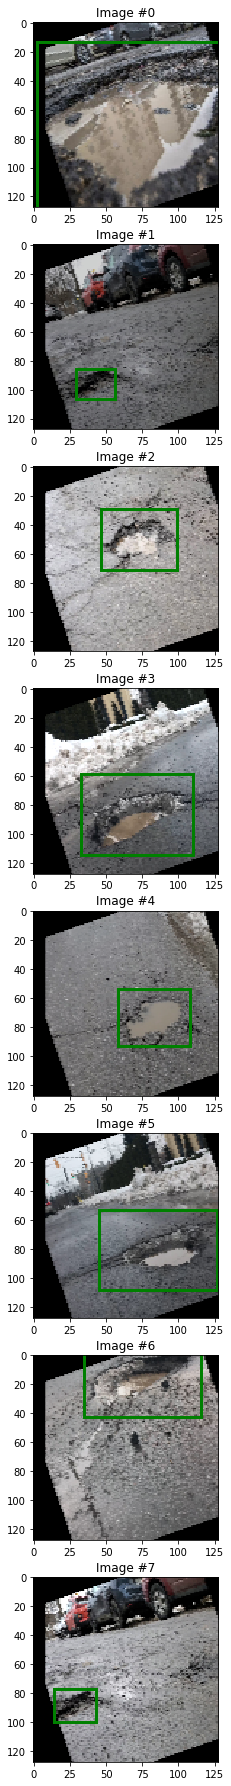

In [112]:
# looking at batch generator

batch_size = 16
num_show=8

gen = PotholeBatchGenerator(X, Y, batch_size, shuffle=True, is_train=True)

bx, by = gen.__getitem__(0)
# print(bx.shape)

i = np.random.randint(batch_size)

fig = plt.figure(figsize=(18,4*num_show))
for i in range(num_show):
    
    [x,y,w,h] = by[i,:]
    
#     print("Y labels:")
#     print((x,y,w,h))
#     print("Sample of X values:")
#     print(bx[i,60,30])
    
    x = x*newSize[0]
    y = y*newSize[1]
    w = w*newSize[0]
    h = h*newSize[1]
    
    
    
    a1 = fig.add_subplot(num_show, 3, i*3+1)
    img1 = a1.imshow(bx[i,:,:,:])
    a1.set_title("Image #{}".format(i))
    rect = pat.Rectangle((x,y),w,h, linewidth = 3, edgecolor='g', facecolor='none')
    print((x,y,w,h))
    a1.add_patch(rect)


### Model design

In [113]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(newSize[0],newSize[1], 3), activation='relu'))
# model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(Conv2D(64, (2,2), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(Conv2D(128, (2,2), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(Conv2D(256, (2,2), activation='relu'))
# model.add(Conv2D(256, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(Dense(128))

model.add(Flatten())
model.add(Dense(4))
model.add(Activation('linear'))



In [114]:
model.compile(optimizer= 'adam', loss='mean_squared_error')

In [115]:
train_gen = PotholeBatchGenerator(X_train, Y_train, 8)
test_gen = PotholeBatchGenerator(X_test, Y_test, 8, is_train=False)

In [116]:
history = model.fit_generator(train_gen, validation_data=test_gen, epochs=30)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 311 steps, validate for 25 steps
Epoch 1/30
311/311 [==============================] - 10s 33ms/step - loss: 0.0295 - val_loss: 0.0469
Epoch 2/30
311/311 [==============================] - 10s 31ms/step - loss: 0.0195 - val_loss: 0.0565
Epoch 3/30
311/311 [==============================] - 10s 31ms/step - loss: 0.0121 - val_loss: 0.0593
Epoch 4/30
311/311 [==============================] - 10s 32ms/step - loss: 0.0076 - val_loss: 0.0507
Epoch 5/30
311/311 [==============================] - 10s 31ms/step - loss: 0.0066 - val_loss: 0.0520
Epoch 6/30
311/311 [==============================] - 10s 31ms/step - loss: 0.0057 - val_loss: 0.0577
Epoch 7/30
311/311 [==============================] - 10s 31ms/step - loss: 0.0047 - val_loss: 0.0468
Epoch 8/30
311/311 [==============================] - 10s 31ms/step - loss: 0.0044 - val_loss: 0.0456
Epoch 9/30
311/311 [==============================] - 10s 31ms/step - loss: 0.0032 - val_lo

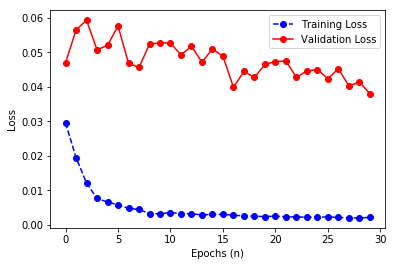

In [117]:
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'] ,'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

## Visualize results

(55.89333333333333, 23.628280639648438)
(86.94339622641509, 81.18618774414062)
(42.66666666666667, 61.22031784057617)
(33.81132075471699, 48.863826751708984)


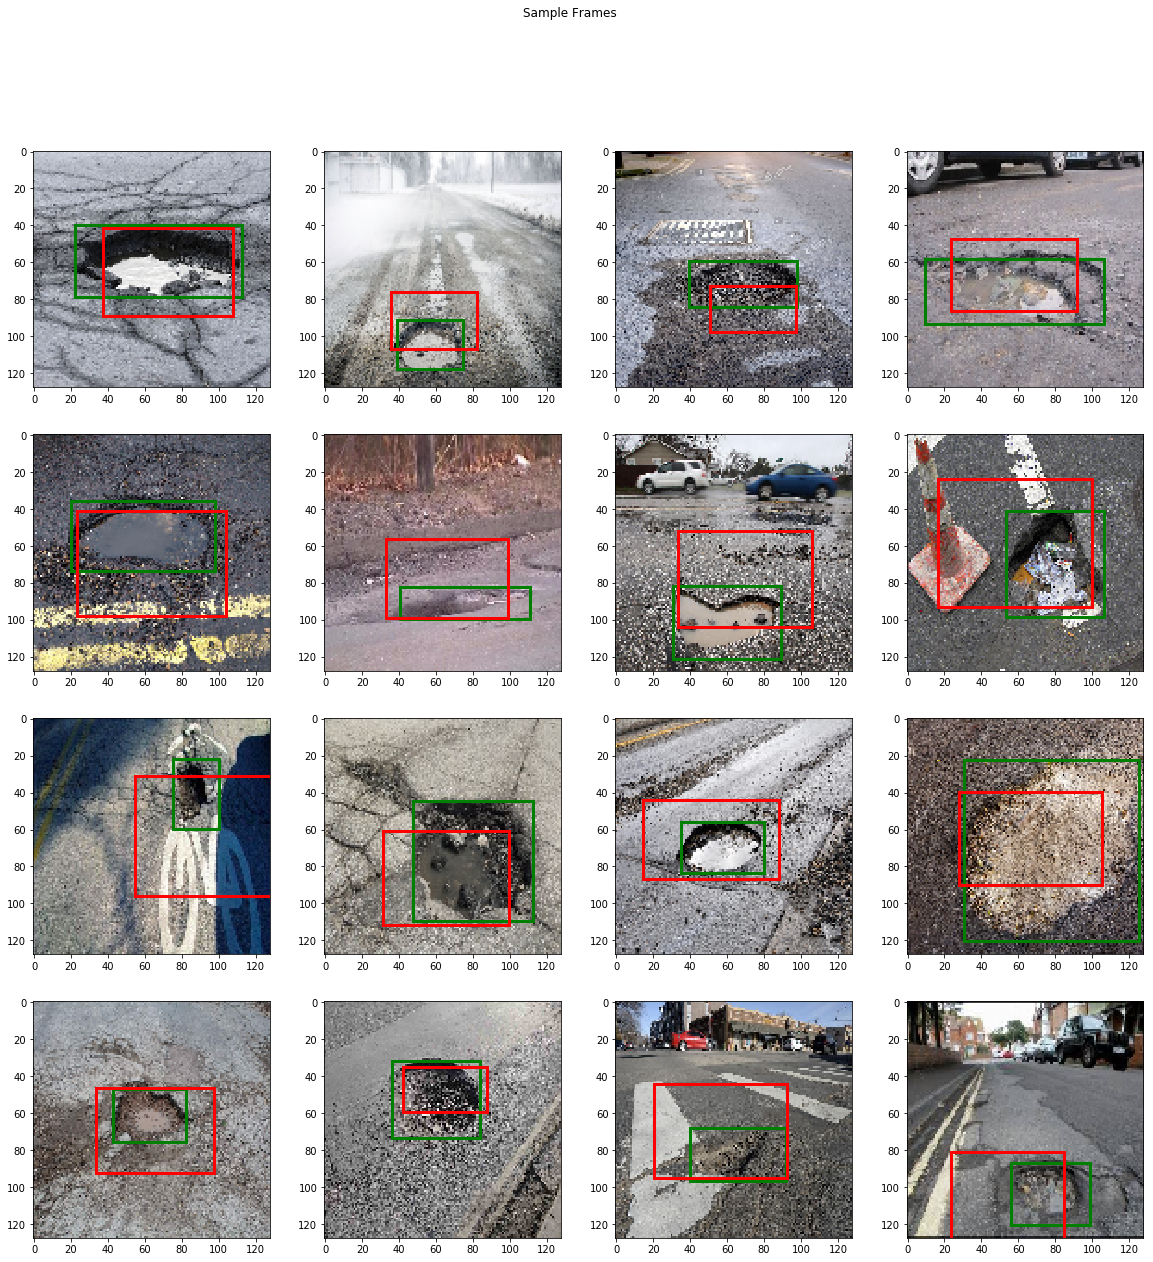

In [118]:
shift = 26
sampleNum = 16
fig, axs = plt.subplots(sampleNum//4, 4, figsize=(20,20))
fig.suptitle("Sample Frames")

for imgNum in range(sampleNum):
    plt.imshow(X_test[imgNum])
    axs[imgNum//4][imgNum%4].imshow(X_test[20+imgNum + shift])
    
    
    [x,y,w,h] = Y_test[20+imgNum + shift]
    [[x1,y1,w1,h1]] = model.predict(np.expand_dims(X_test[20+imgNum + shift], axis=0))
    
    x = x*newSize[0]
    y = y*newSize[1]
    w = w*newSize[0]
    h = h*newSize[1]

    x1= x1*newSize[0]
    y1= y1*newSize[1]
    w1= w1*newSize[0]
    h1= h1*newSize[1]

    rect = pat.Rectangle((x,y),w,h, linewidth = 3, edgecolor='g', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect)
    rect1 = pat.Rectangle((x1,y1),w1,h1, linewidth = 3, edgecolor='r', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect1)
print((x,x1))
print((y,y1))
print((w,w1))
print((h,h1))

In [119]:
from datetime import datetime
timeStamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_file_path = os.path.join(absFolder, "model_" + timeStamp +"mse"+ ".h5")
model.save(model_file_path)
print("Model saved to {}".format(model_file_path))

Model saved to /home/jupyter/Robo-Traverse/Notebooks/model_2020-02-22_18-45-42mse.h5
